# How to use CNN with time series data

The regular measurements of time series result in a similar grid-like data structure as for the image data we have focused on so far. As a result, we can use CNN architectures for univariate and multivariate time series. In the latter case, we consider different time series as channels, similar to the different color signals.

We will illustrate the time series use case with the univariate asset price forecast example we introduced in the last chapter. Recall that we create rolling monthly stock returns and use the 24 lagged returns alongside one-hot-encoded month information to predict whether the subsequent monthly return is positive or negative.

## Imports & Settings

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import keras
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers.normalization import BatchNormalization
from keras import backend as K

Using TensorFlow backend.


## Prepare Data

In [2]:
data = pd.read_hdf('data.h5', 'returns')
data = data.drop([c for c in data.columns if str(c).startswith('year')], axis=1)

In [3]:
X_train = data[:'2016'].drop('label', axis=1)
y_train = data[:'2016'].label
X_test = data['2017'].drop('label', axis=1)
y_test = data['2017'].label

In [4]:
X_train = X_train.values.reshape(-1, X_train.shape[1], 1)
X_test = X_test.values.reshape(-1, X_train.shape[1], 1)

## Define Custom AUC Metric

In [5]:
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.metrics.auc(y_true, y_pred)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

## Build ConvNet

### Model Architecture

We design a simple one-layer CNN that uses one-dimensional convolutions combined with max pooling to learn time series patterns:

In [6]:
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),       
    Flatten(),
    Dense(1, activation='relu'),
    Activation('sigmoid')])

The model has 673 trainable parameters:

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 34, 32)            128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 17, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 544)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 545       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 673
Trainable params: 673
Non-trainable params: 0
_________________________________________________________________


We compile using our custom auc_roc metric developed in the last chapter:

In [8]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['binary_accuracy', auc_roc])

We train on returns for the years 2010-16 for 20 epochs using the default batch size of 32. Each epoch takes around 13s on a single NVIDIA GTX 1080 GPU.

In [9]:
training = model.fit(X_train,
                     y_train, 
                     epochs=20,
                     batch_size=32, 
                     validation_data=(X_test, y_test),
                     shuffle=True,
                     verbose=1)

Train on 206587 samples, validate on 29868 samples
Epoch 1/20
206587/206587 [==============================] - 14s 66us/step - loss: 0.6727 - binary_accuracy: 0.5845 - auc_roc: 0.5991 - val_loss: 0.7233 - val_binary_accuracy: 0.5206 - val_auc_roc: 0.6033
Epoch 2/20
206587/206587 [==============================] - 14s 68us/step - loss: 0.6687 - binary_accuracy: 0.5935 - auc_roc: 0.6037 - val_loss: 0.7170 - val_binary_accuracy: 0.5205 - val_auc_roc: 0.6056
Epoch 3/20
206587/206587 [==============================] - 13s 65us/step - loss: 0.6670 - binary_accuracy: 0.5955 - auc_roc: 0.6067 - val_loss: 0.7242 - val_binary_accuracy: 0.5268 - val_auc_roc: 0.6076
Epoch 4/20
206587/206587 [==============================] - 13s 62us/step - loss: 0.6659 - binary_accuracy: 0.5960 - auc_roc: 0.6084 - val_loss: 0.7191 - val_binary_accuracy: 0.5438 - val_auc_roc: 0.6092
Epoch 5/20
206587/206587 [==============================] - 13s 63us/step - loss: 0.6652 - binary_accuracy: 0.5969 - auc_roc: 0.6097 

In [10]:
accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
print('Accuracy: {:.2%}'.format(accuracy))

Accuracy: 58.28%


For 2017 returns, we find a test accuracy of 58.28% and test AUC of 0.5701. The network is still underfitting at this point because both training and validation AUC are still improving after 20 epochs, suggesting that longer training and potentially a higher-capacity network would improve results. You should try!

In [11]:
y_score = model.predict(X_test)
roc_auc_score(y_score=y_score, y_true=y_test)

0.5709754730834962

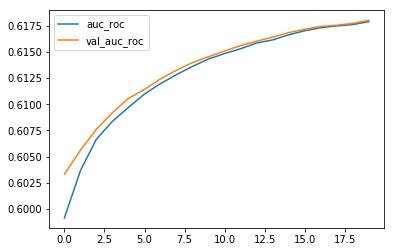

In [13]:
pd.DataFrame(training.history)[['auc_roc', 'val_auc_roc']].plot();